# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead.

## Training

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Done with batch 1
Done with batch 101
Done with batch 201
Done with batch 301
Done with batch 401
Done with batch 501
Done with batch 601
Done with batch 701
Done with batch 801
Done with batch 901
Done with batch 1001
Done with batch 1101
Done with batch 1201
Done with batch 1301
Done with batch 1401
Done with batch 1501
Done with batch 1601
Done with batch 1701
Done with batch 1801
Done with batch 1901


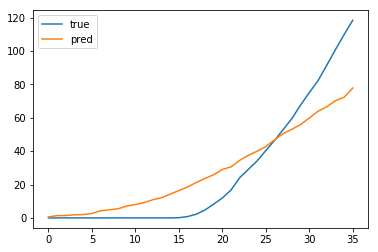

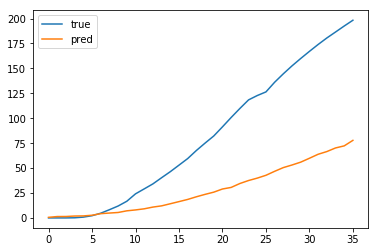

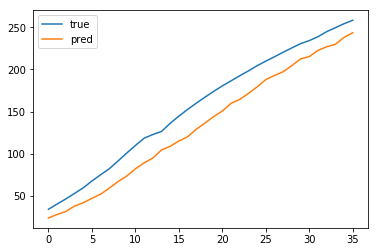

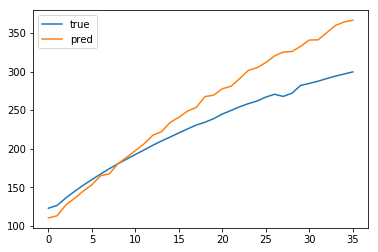

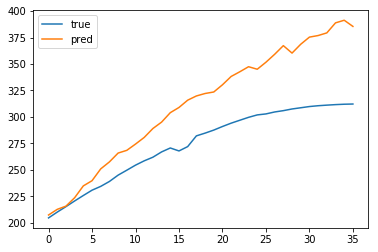

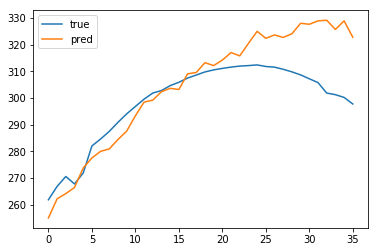

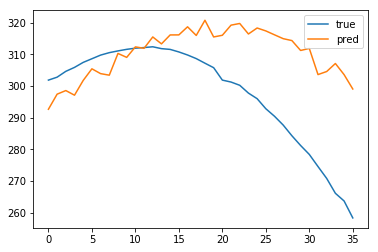

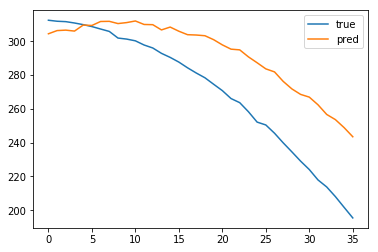

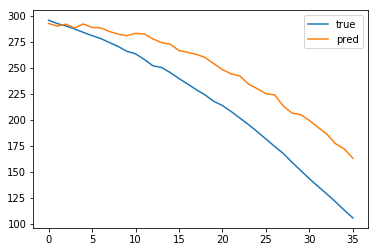

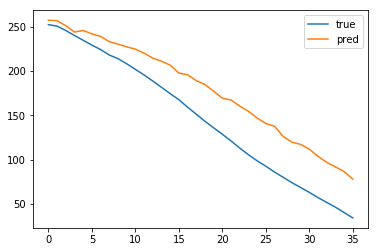

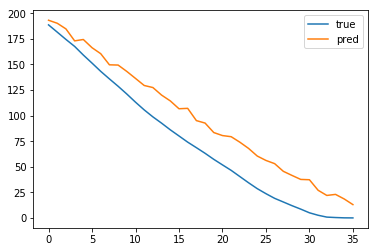

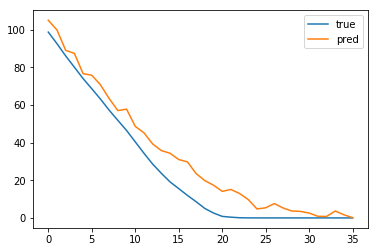

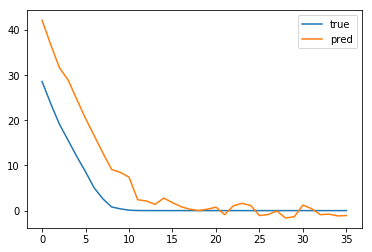

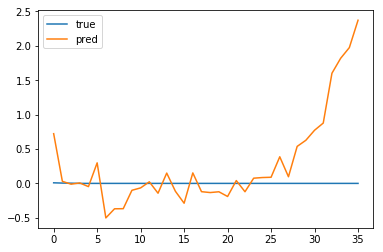

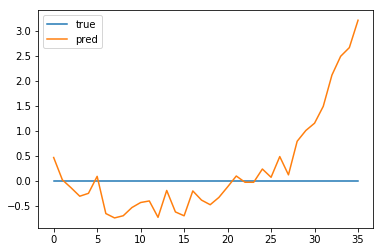

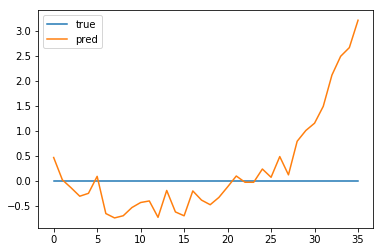

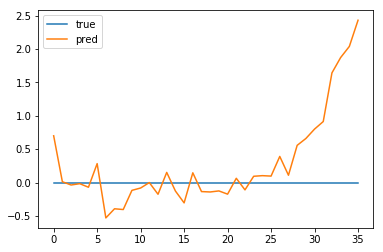

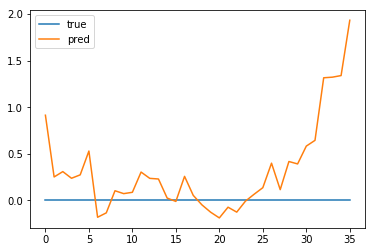

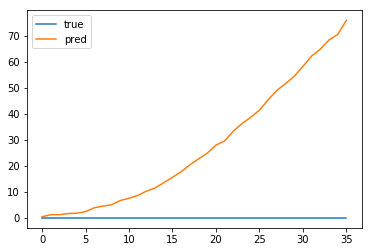

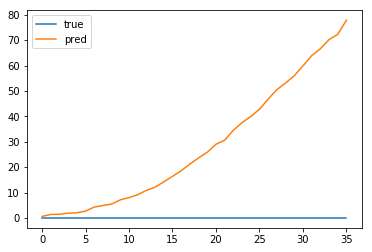

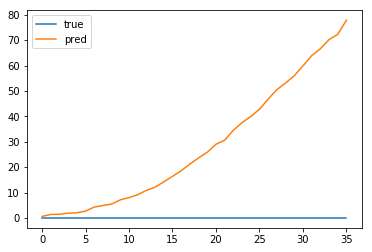

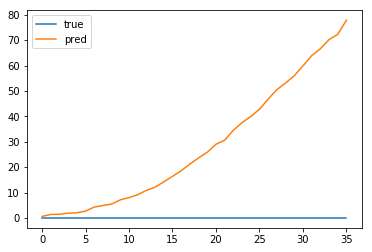

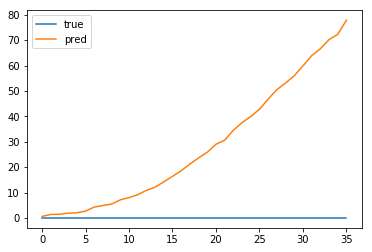

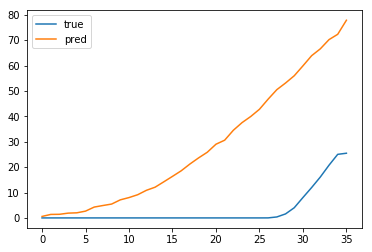

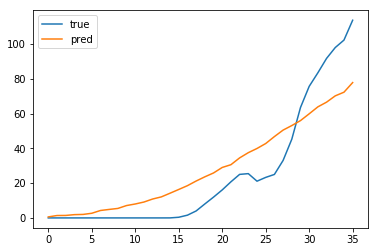

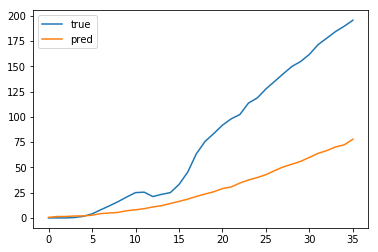

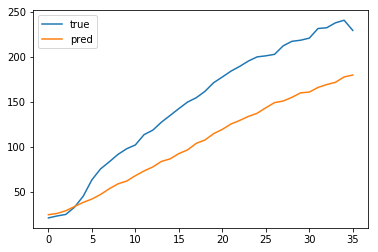

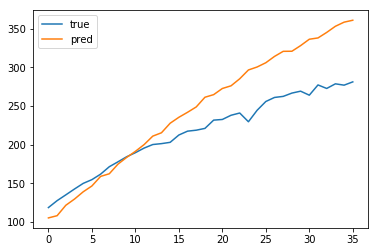

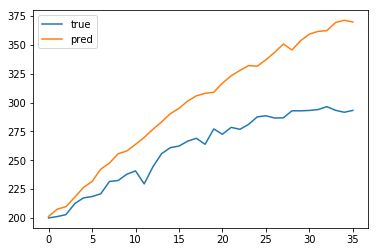

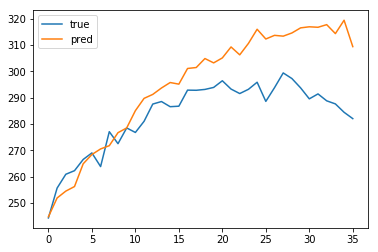

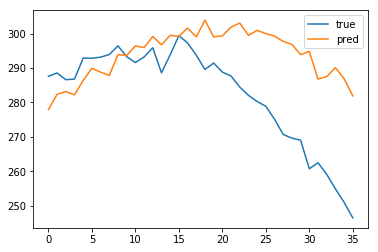

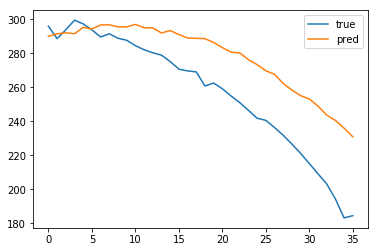

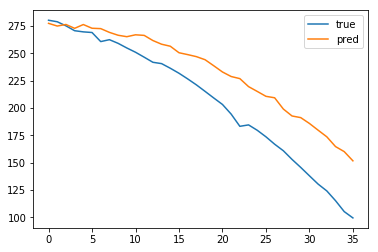

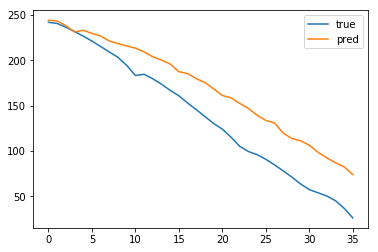

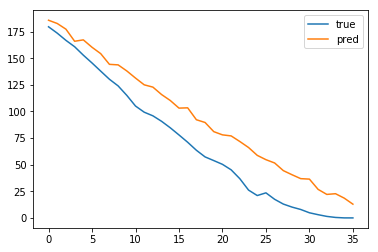

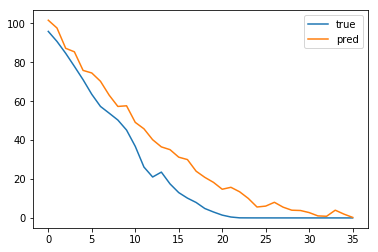

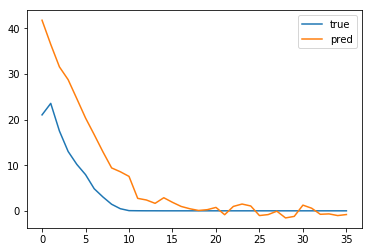

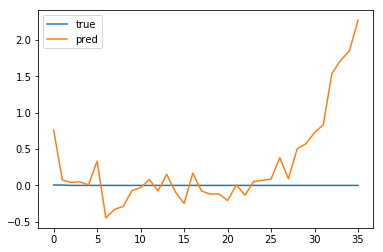

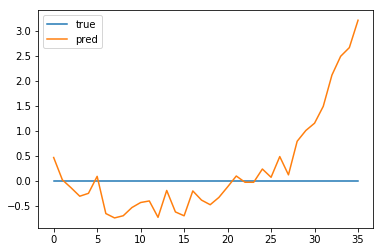

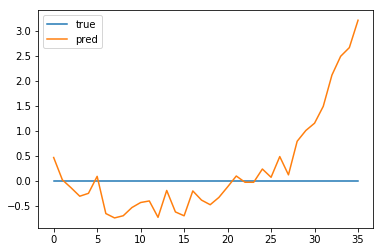

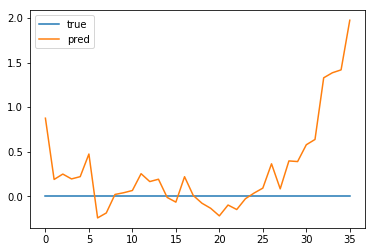

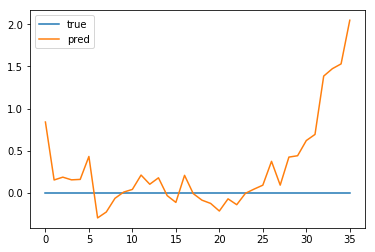

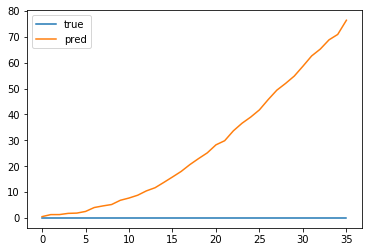

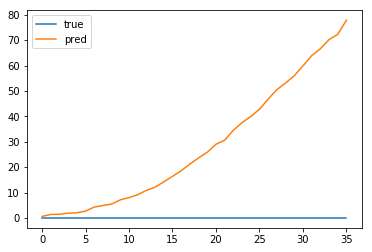

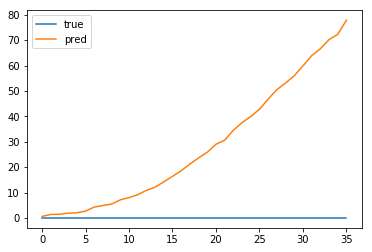

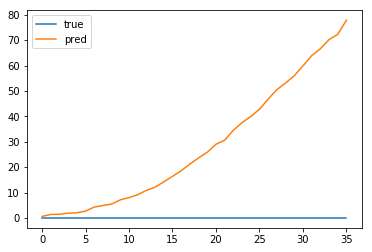

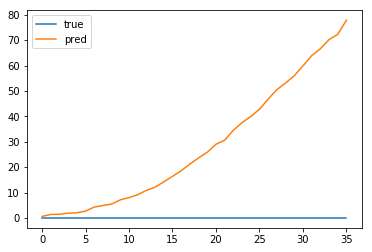

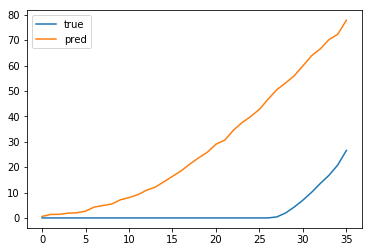

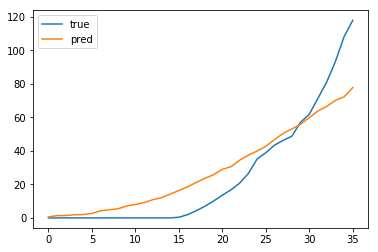

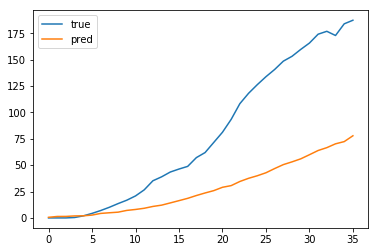

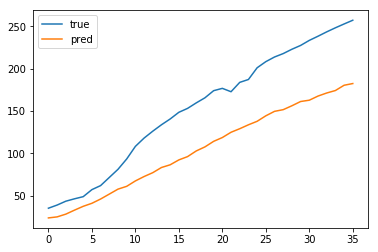

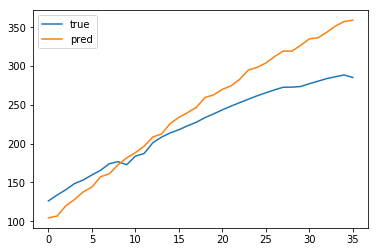

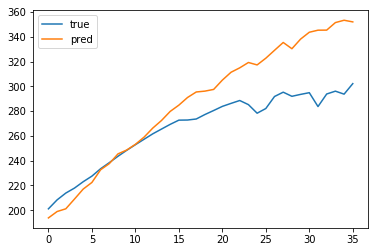

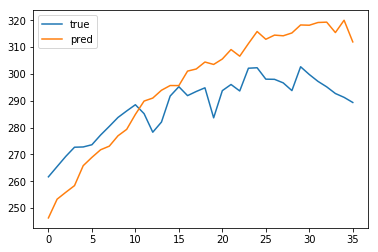

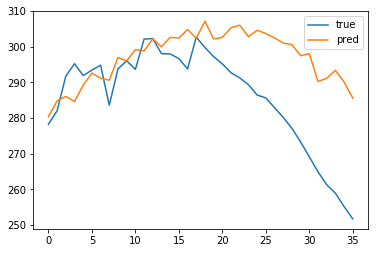

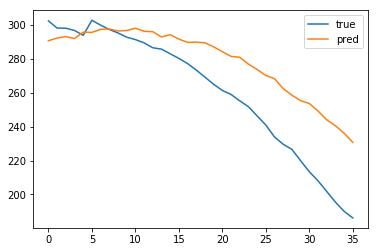

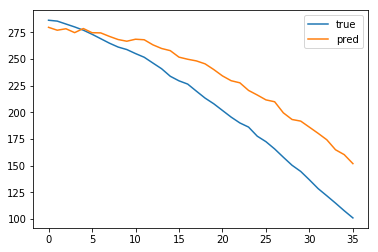

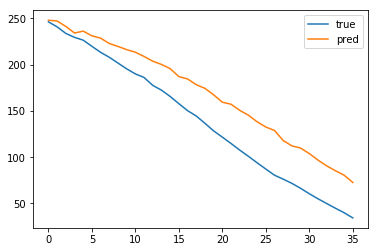

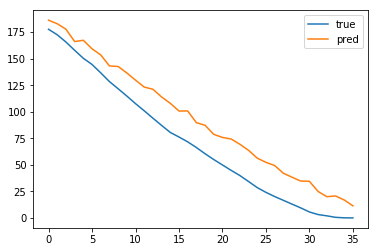

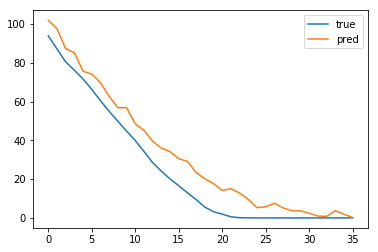

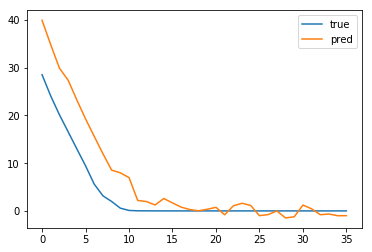

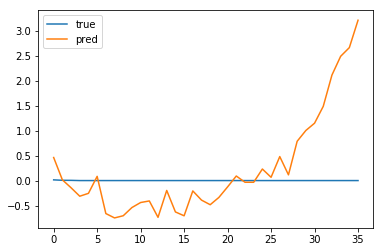

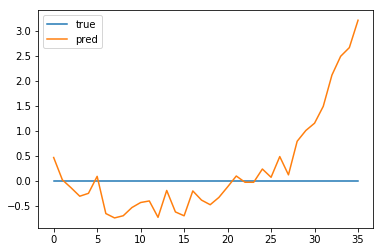

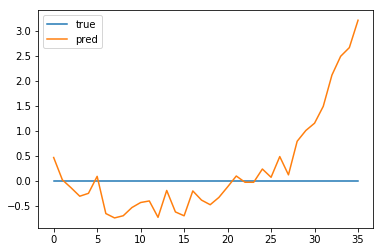

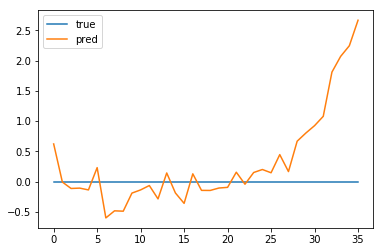

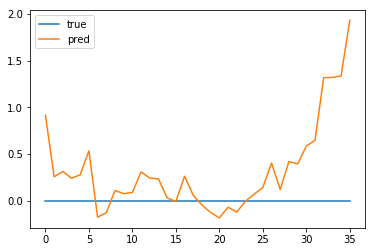

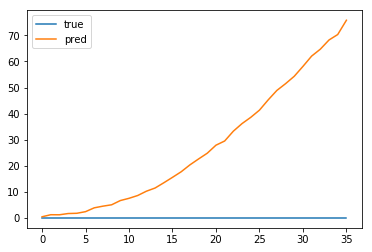

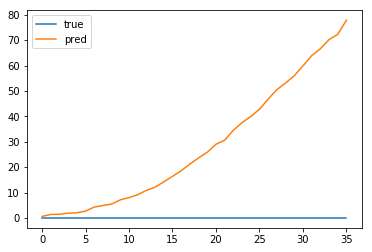

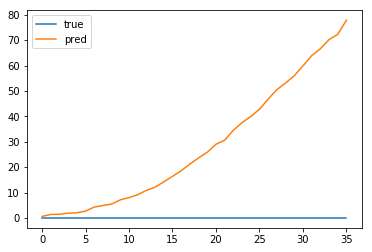

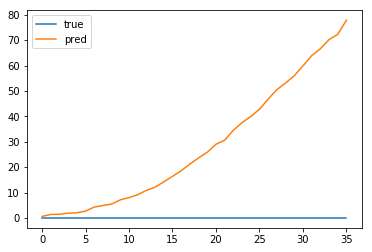

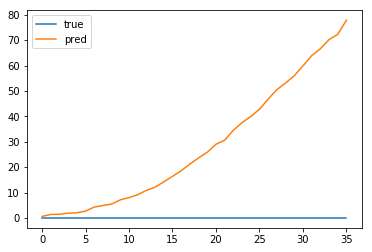

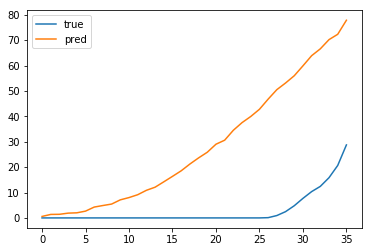

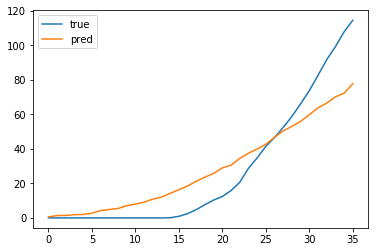

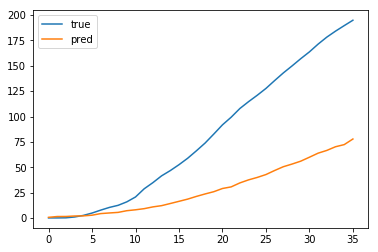

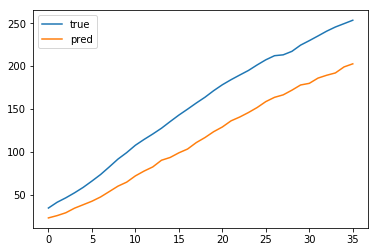

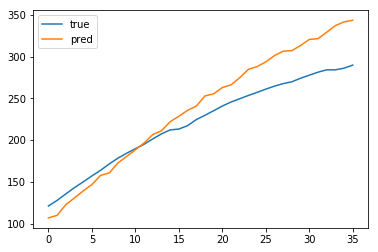

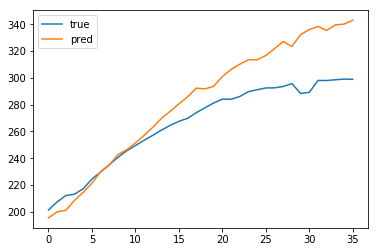

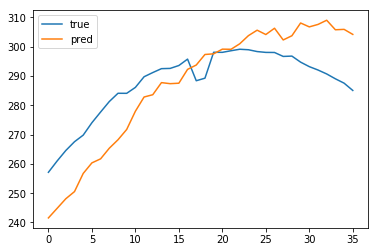

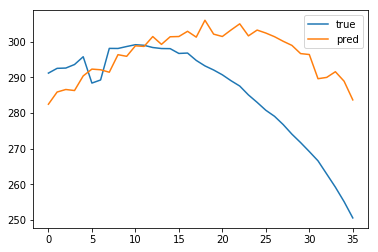

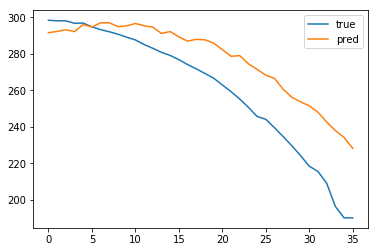

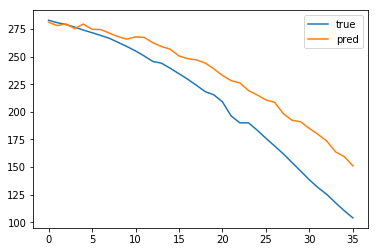

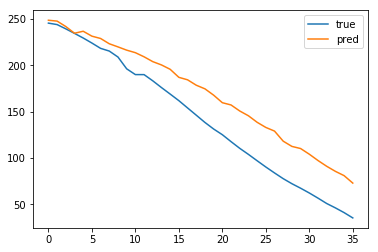

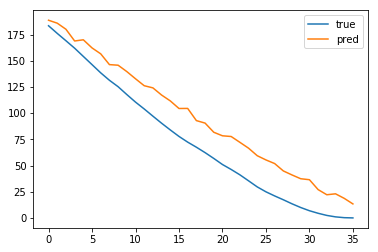

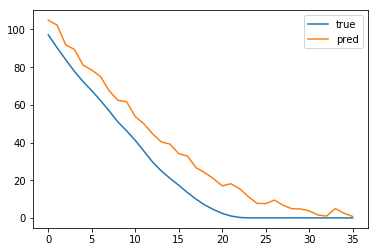

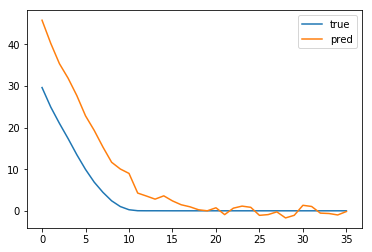

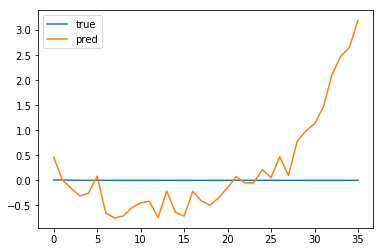

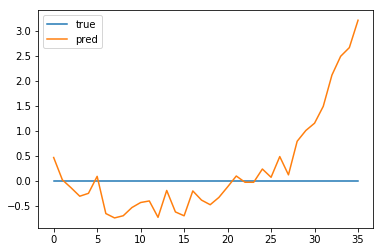

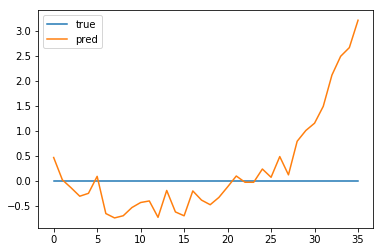

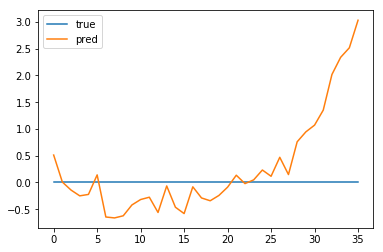

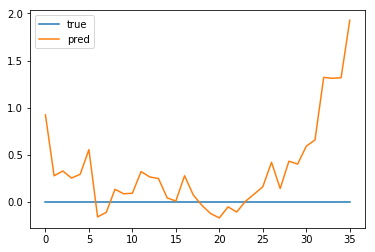

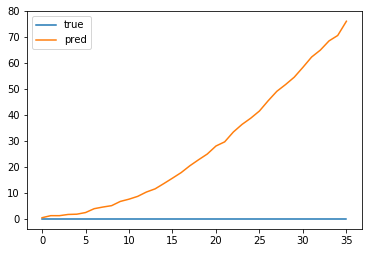

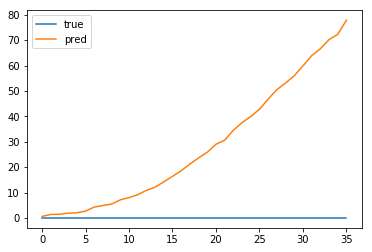

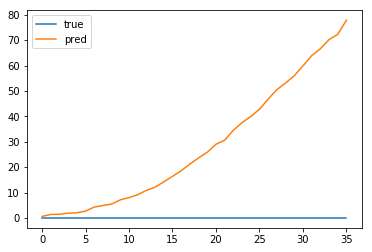

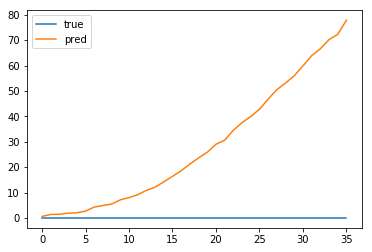

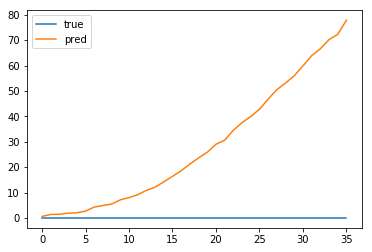

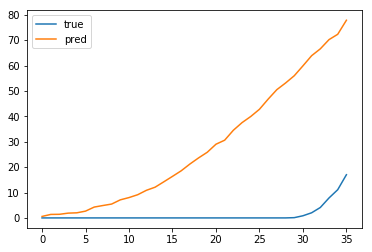

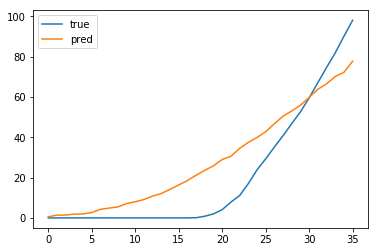

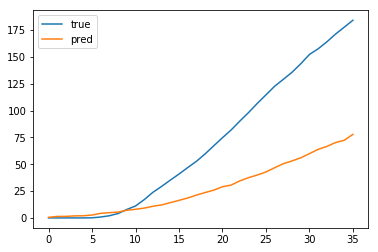

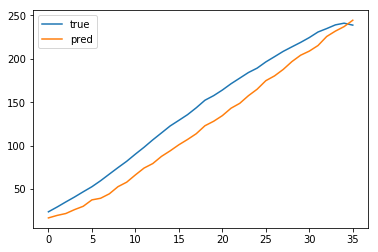

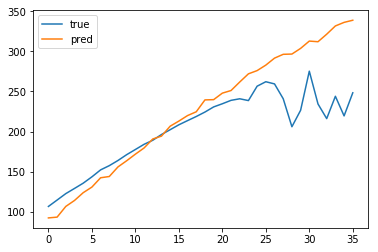

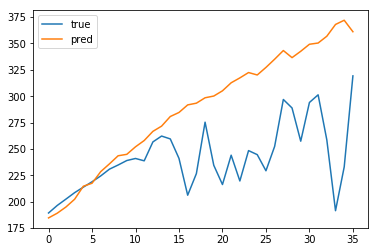

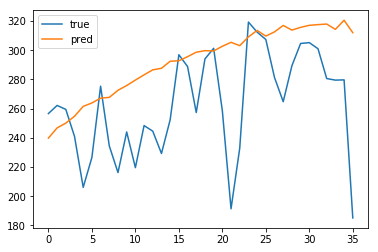

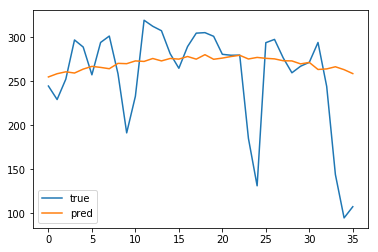

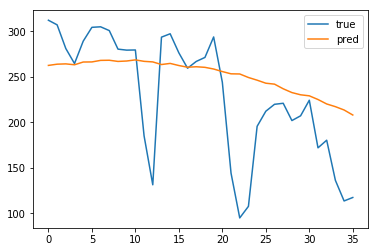

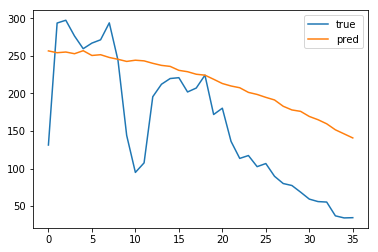

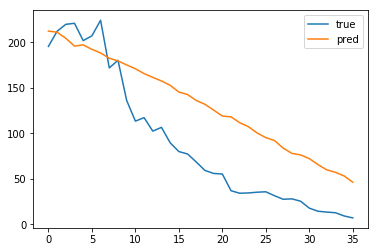

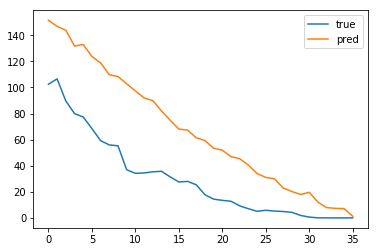

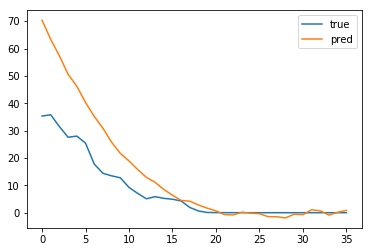

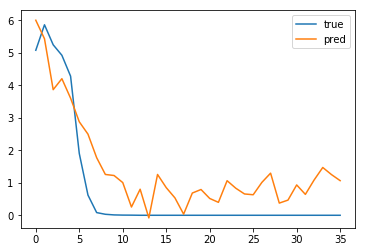

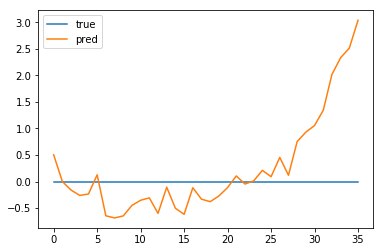

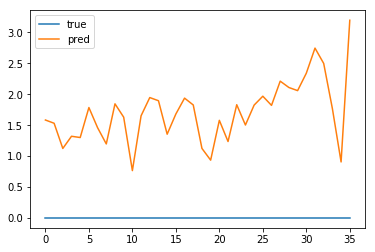

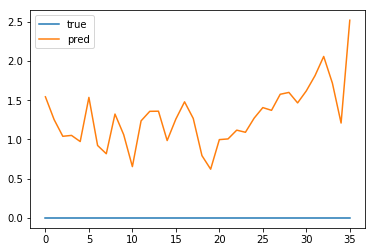

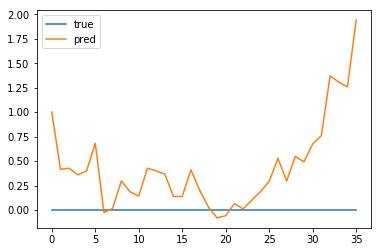

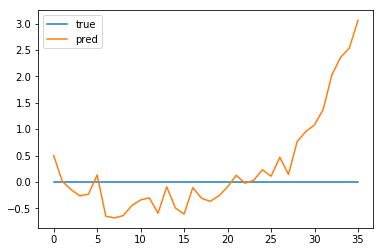

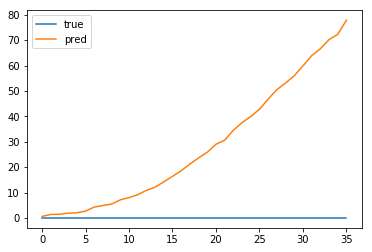

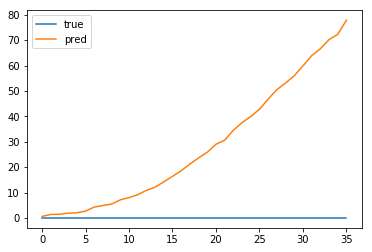

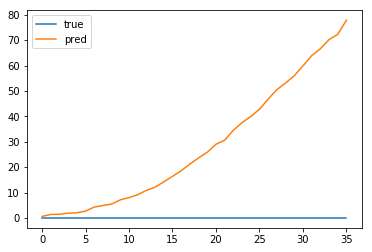

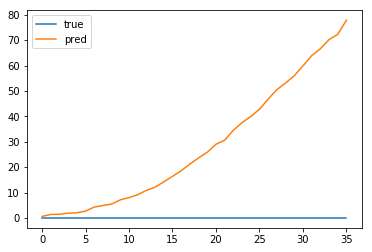

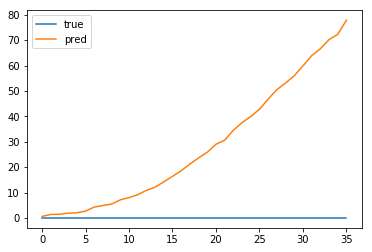

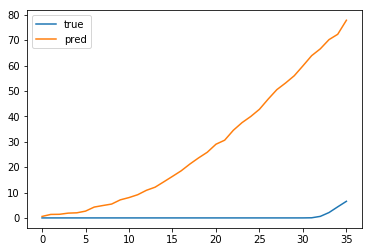

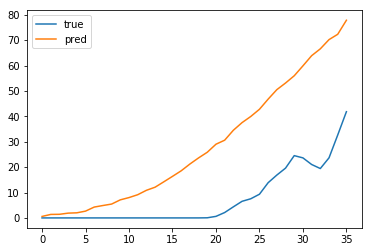

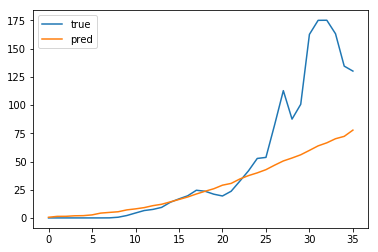

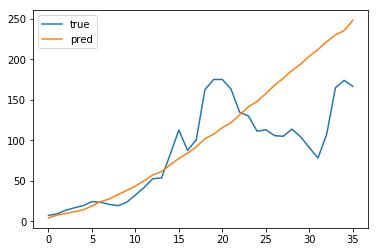

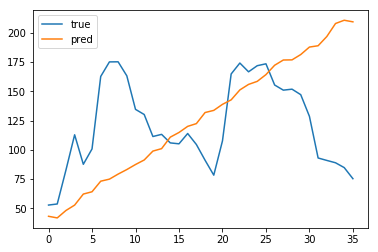

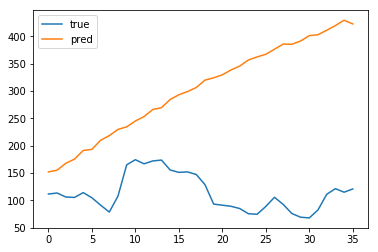

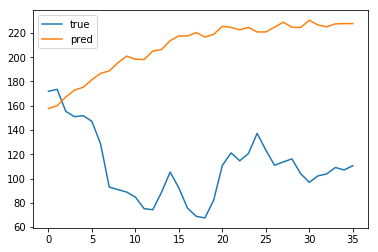

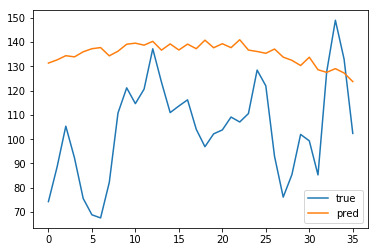

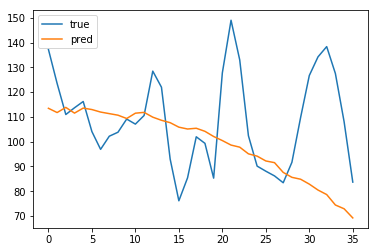

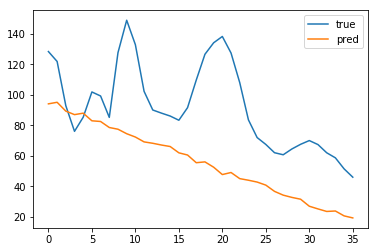

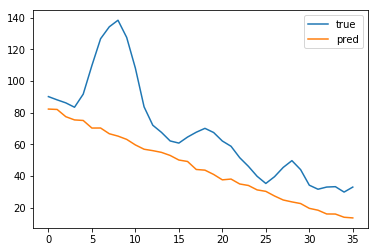

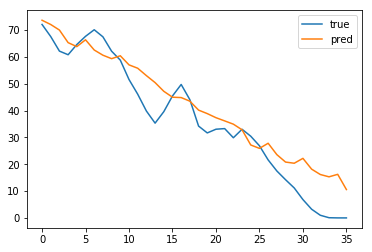

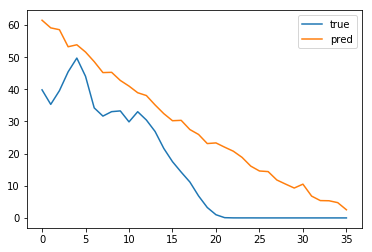

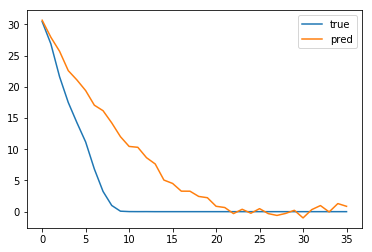

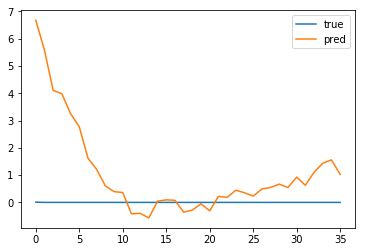

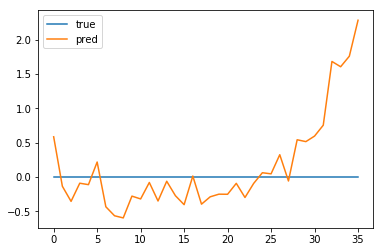

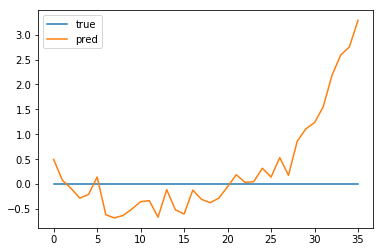

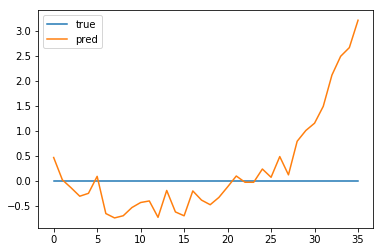

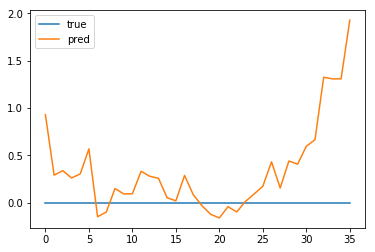

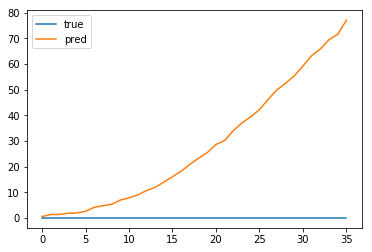

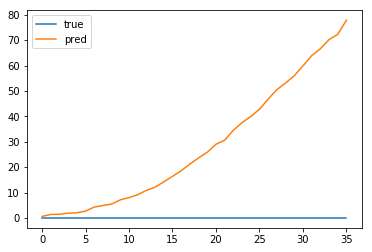

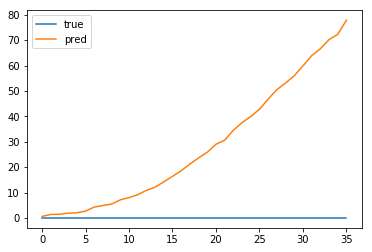

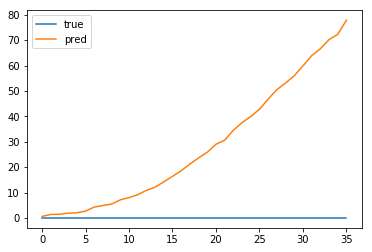

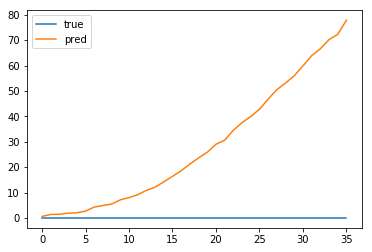

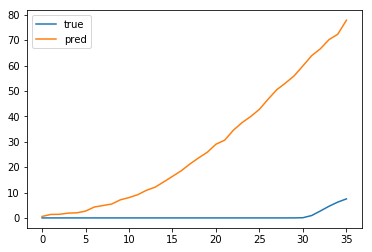

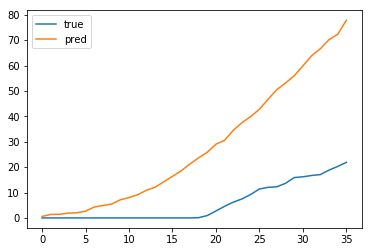

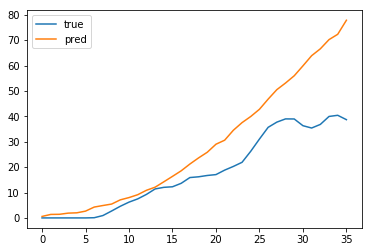

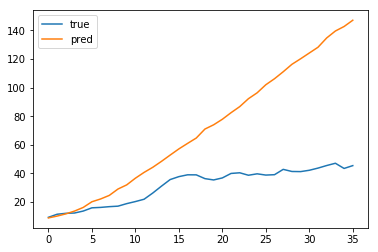

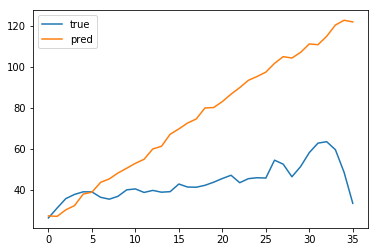

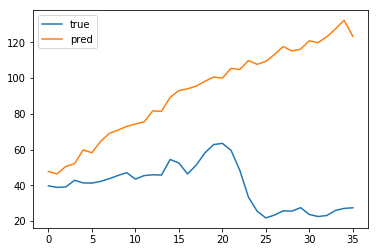

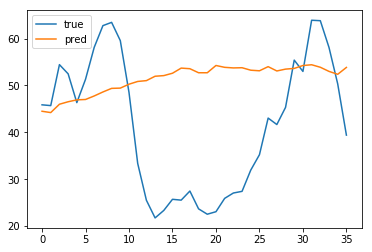

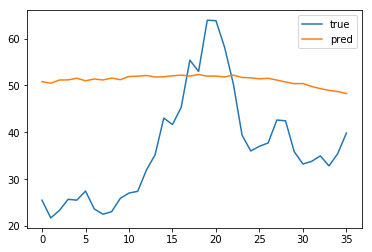

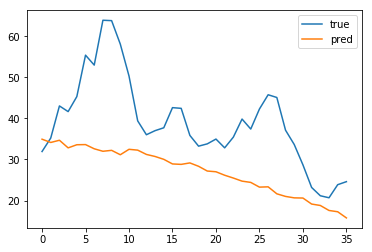

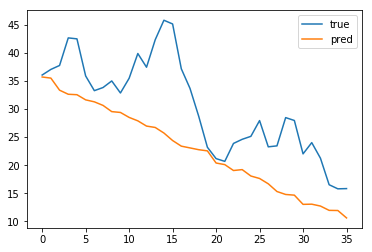

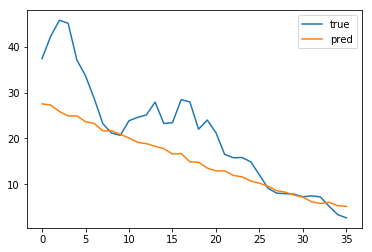

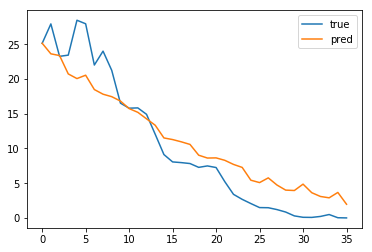

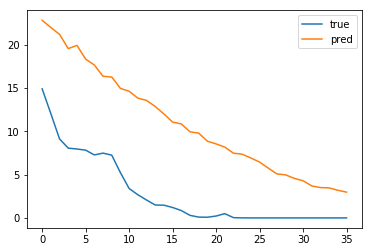

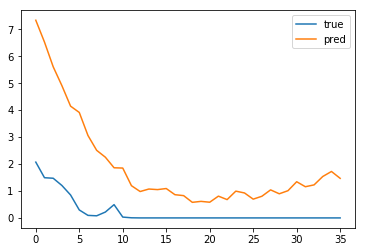

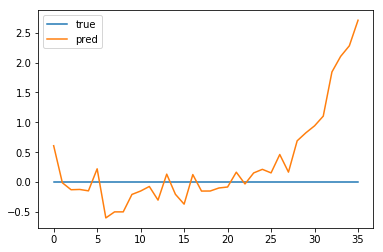

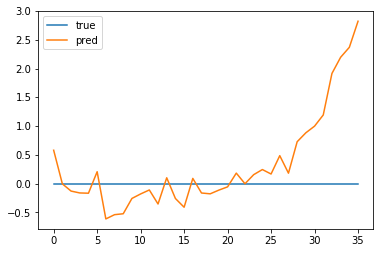

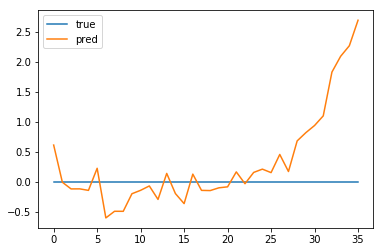

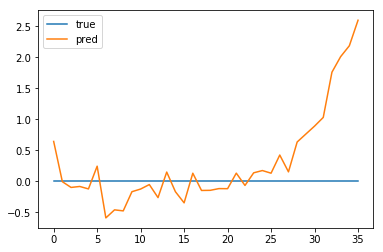

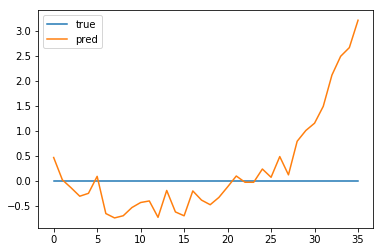

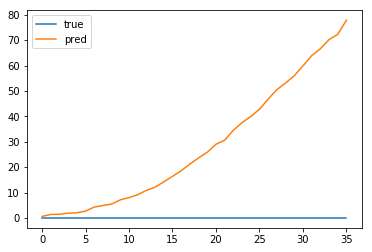

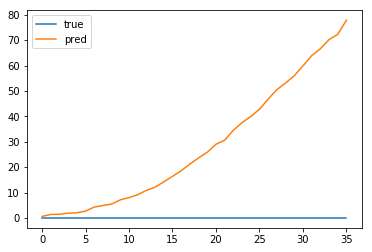

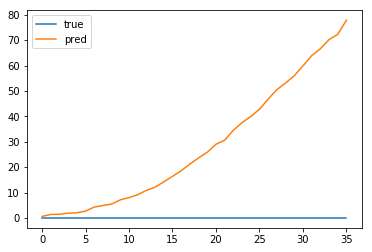

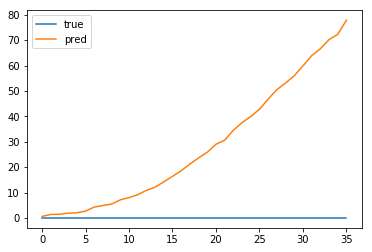

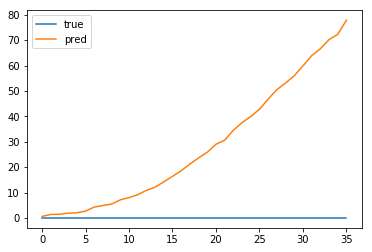

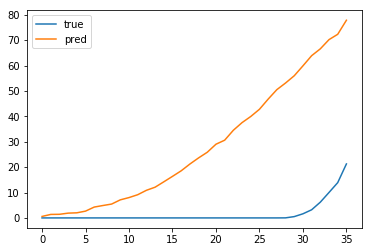

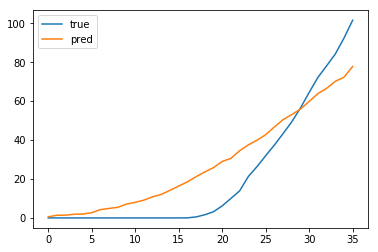

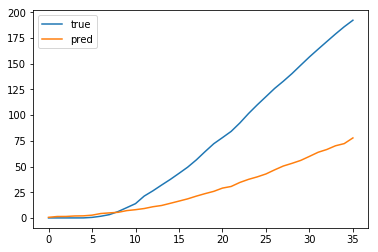

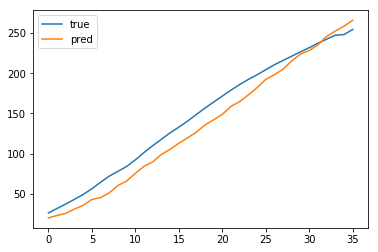

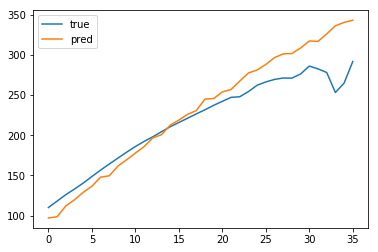

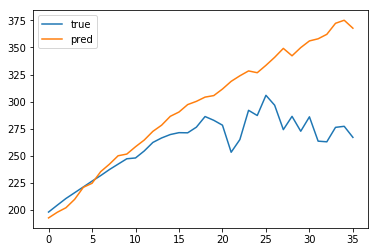

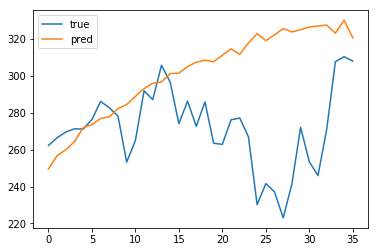

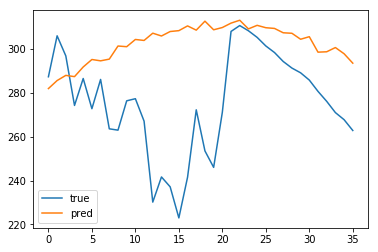

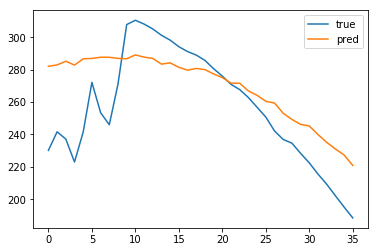

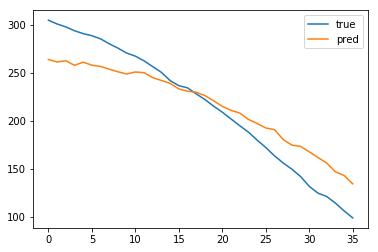

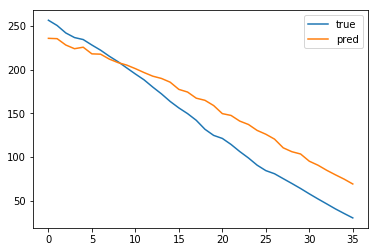

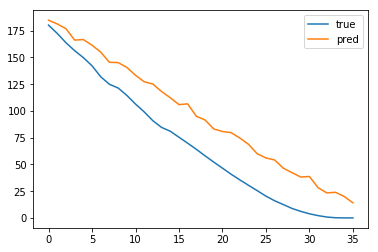

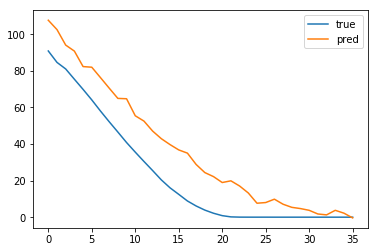

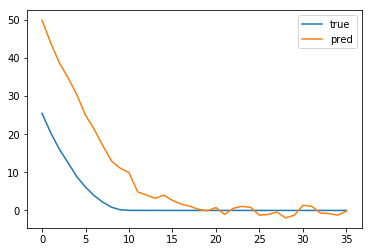

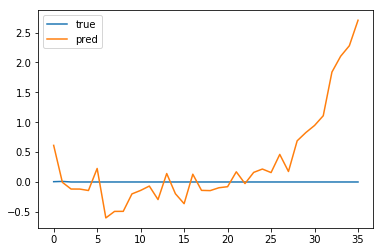

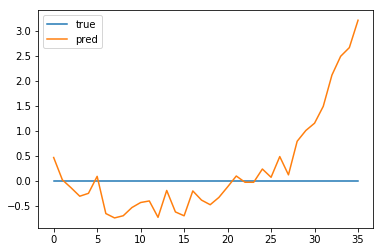

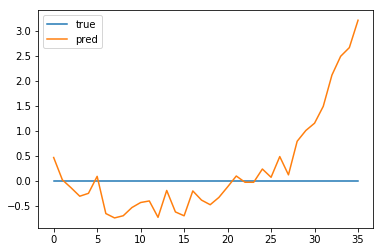

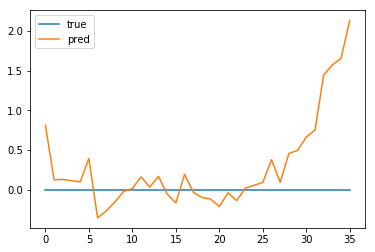

In [1]:
import core.preprocessing as pp
from core.neural_net_forecaster import NeuralNetForecaster

dm = pp.DataManager()
dm.load_all_and_split(kind='small', reindex=True)
dftrain = dm.original_train
dfdev = dm.original_dev

problem = NeuralNetForecaster(dftrain, dfdev, arch='FC', nepochs=2000, batchsize=100, rmlogdir=False)

problem.make_forecasts()

## Prediction

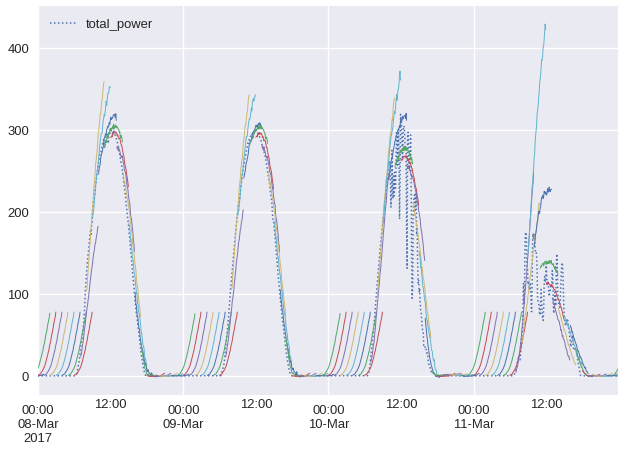

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk')

problem.plot_test()

ax = plt.gca()
lim = ax.get_xlim()
chunk = (lim[1] - lim[0])/8.
start = lim[0] + 2*chunk
end = lim[0] + 6*chunk

ax.set_xlim(start, end)

plt.show()

In [3]:
# Add the forecasts to the DataManager class
dm.add_forecasts(problem.forecasts)
# Use data manager class to change all indices back to "real time"
dm.swap_index()

In [4]:
# With the forecasts in "real time" the default retrending function may be used
transformed_forecasts = [pp.retrend_data(f) for f in dm.forecasts]

In [5]:
# Translate back to "sequential time" for plotting
dm.add_forecasts(transformed_forecasts)
dm.swap_index()

(24815518.75, 24821276.25)

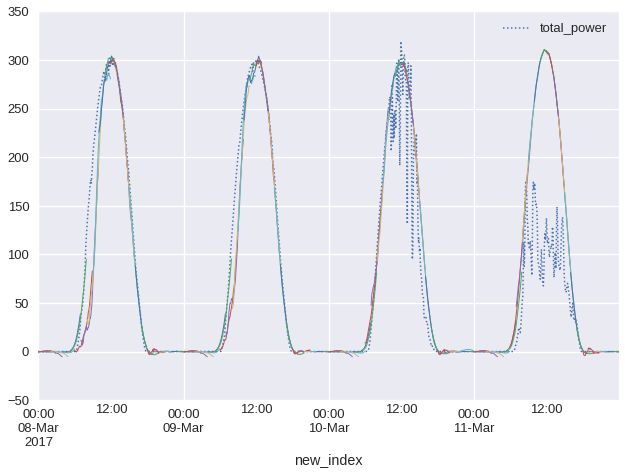

In [6]:
from core.utilities import plot_forecasts

plot_forecasts(dm.original_dev, dm.forecasts)
ax = plt.gca()
lim = ax.get_xlim()
chunk = (lim[1] - lim[0])/8.
start = lim[0] + 2*chunk
end = lim[0] + 6*chunk
ax.set_ylim(-50, 350)
ax.set_xlim(start, end)

In [3]:
problem.calc_mse()

1585.3402210320517